<a href="https://colab.research.google.com/github/praveenraghuvanshi/eva4-p2-group/blob/master/Session-2/Assignment-2/src/eva4p2s2_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment -2 MobileNet_V2 on Custom Dataset

### Team Members
- Praveen Raghuvanshi (praveenraghuvanshi@gmail.com)
- Tusharkanta Biswal (Tusharkanta_biswal@stragure.com)
- Suman Kanukollu (sumankanukollu@gmail.com)
- Shubham Kothawade (kothawadeshub@gmail.com)


Tasks
---
1. Load images into dataloader from zip file
2. Resize image if required to 224x224x3
3. Split dataset
4. Load Mobilenet_V2 model with pretrained=false
5. Modify classification layer to output 4 classes only
6. Train model
7. Save model
8. Use new model in serverless.yml
9. Deploy to AWS
10. Test with rest client
11. Done :-)

System Information
---

In [1]:
!nvidia-smi

Sun Aug  9 18:27:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install torch==1.5.1+cu92 torchvision==0.6.1+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 604.8MB 28kB/s 
     |████████████████████████████████| 6.5MB 60.9MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [3]:
import torch
from IPython.display import Image, clear_output 

print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.5.1+cu92 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)


Mount google drive
---


In [4]:
# Load data from Google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Install libraries
---

**Helper**
- autotime : Prints cell execution time
- torchsummary : Prints model summary

In [5]:
!pip install ipython-autotime
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=9ccabd576da972578b24256859acab84d7f5f25f68dab781f5f8bf11d864857b
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


Import all modules and libraries
---


In [6]:
# System
import os
import sys

# Scikit
import numpy as np

# Plotting
from matplotlib import pyplot as plt

# Pytorch
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchsummary import summary
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR

# Image Proessing
import PIL
from PIL import Image


# File Processing
from zipfile import ZipFile

time: 197 ms


Application constants
---


In [7]:
BASE_COLAB_PATH = '/content/drive/My Drive/eva-4/Phase-2/Session-2'
DATASET_FILE = 'dataset.zip'
MODEL_FILE = 'model.pt'
MODEL = 'mobilenet_v2'

time: 924 µs


Set Device
---

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda
time: 1.3 ms


Hyperparameters
---


In [9]:
EPOCHS=200
BATCH_SIZE=256
LEARNING_RATE=0.01
MOMENTUM = 0.9
STEP_SIZE = 2
GAMMA = 0.96
PATIENCE = 10

IMAGE_WIDTH=224
IMAGE_HEIGHT=224
INPUT_CHANNELS=3

time: 2.17 ms


Utility Methods
---

In [10]:
# Unzip Dataset
def unzip(file):
  directory = os.path.splitext(file)[0]
  if not os.path.exists(directory):
    !unzip file
    print('Extracted!')
  else:
    print('Already extracted!')


time: 2.26 ms


In [11]:
# Visualize dataset
%matplotlib inline

def visualizedataset(file, title='Dataset Summary'):
  datasetDirectory = os.path.splitext(file)[0]
  plt.pie( 
          list(map(lambda f : len(os.listdir(os.path.join(datasetDirectory,f))), os.listdir(datasetDirectory))),
          labels = os.listdir(datasetDirectory) ,
          autopct='%0.1f')

  plt.title(title)
  plt.show()

time: 10.2 ms


In [12]:
# Load transformers
def loadtransformers():
  transform = torchvision.transforms.Compose([#torchvision.transforms.Resize([224,224]),
                                #torchvision.transforms.CenterCrop(224),
                                torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
                                torchvision.transforms.RandomHorizontalFlip(),
                                torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(mean=[0.5332, 0.5855, 0.6169],std=[0.1747, 0.1697, 0.1862])])
  return transform

time: 6.05 ms


In [13]:
# Load dataset
def loaddataset(root, transformation, batch_size=32, split_factor=0.7):
    dataset = torchvision.datasets.ImageFolder(root, transformation)
    train_size = int(split_factor * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    
    return (train_loader, val_loader)

time: 4.35 ms


In [14]:
# Show Images
def show(imgs,lbls=None, figsize=(100,100), *args, **kwargs):
    grid_tensor = torchvision.utils.make_grid(imgs[:8], *args, **kwargs)
    grid_image = grid_tensor.permute(1,2,0)
    plt.figtext(100,100,'Images')
    plt.figure(figsize=figsize)
    plt.imshow(grid_image)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    if lbls is not None:
        print(' '.join('%22s' % [lbls[j]] for j in range(10)))
    plt.close()

time: 8.31 ms


In [15]:
# visualize the loss as the network trained
def displayloss(train_loss, valid_loss):
  fig = plt.figure(figsize=(10,8))
  plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
  plt.plot(range(1,len(valid_loss)+1),valid_loss, label='Validation Loss')

  # find position of lowest validation loss
  minposs = valid_loss.index(min(valid_loss))+1 
  plt.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')

  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.ylim(0, max(train_loss) + 0.2) # consistent scale
  plt.xlim(0, len(train_loss)+1) # consistent scale
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()
  fig.savefig('loss_plot.png', bbox_inches='tight')

time: 14 ms


In [16]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    #input = image
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

time: 5.07 ms


In [17]:
def get_random_images(num):
    dataiter = iter(val_loader)
    images, labels = dataiter.next()
    return images, labels

time: 3.46 ms


In [18]:
def imshow(img):
		img = img / 2 + 0.5   # first convert back to [0,1] range from [-1,1] range
		npimg = img.numpy()
		# convert from CHW to HWC
		# from 3x32x32 to 32x32x3
		plt.imshow(np.transpose(npimg, (1, 2, 0)))

time: 3.57 ms


In [19]:
def plot_misclassified_images_for_class(model, testloader, classid, figsize=(15,12), num_of_images = 20, nrow=4, save_filename=None):
		model.eval()
		misclassified_cnt = 0
		ncol = num_of_images/nrow
		fig = plt.figure(figsize=figsize)
		for data, target in testloader:
			data, target = data.to(device), target.to(device)
			output = model(data)
			pred = output.argmax(dim=1, keepdim=True)     # get the index of the max log-probability
			pred_marker = pred.eq(target.view_as(pred))   
			wrong_idx = (pred_marker == False).nonzero()  # get indices for wrong predictions
			for idx in wrong_idx:
				index = idx[0].item()
				if(target[index].item() == classid):
					title = "T:{}, P:{}".format(classes_short[target[index].item()], classes_short[pred[index][0].item()])
					ax = fig.add_subplot(nrow, ncol, misclassified_cnt+1, xticks=[], yticks=[])
					#ax.axis('off')
					ax.set_title(title)
					imshow(data[index].cpu())
					misclassified_cnt += 1
					if(misclassified_cnt==num_of_images):
						break
			if(misclassified_cnt==num_of_images):
			  break

		if save_filename:
			fig.savefig(save_filename)
		return

time: 19.1 ms


In [20]:
# Early stopping

class EarlyStoppingOnAcc:
    def __init__(self, patience=7, mode="max", delta=0.0001, model_path='checkpoint.pt'):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.model_path = model_path
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):
        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(
                "EarlyStopping counter: {} out of {}".format(
                    self.counter, self.patience
                )
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print(
                "Validation score improved ({} --> {}). Saving model!".format(
                    self.val_score, epoch_score
                )
            )
            torch.save(model.state_dict(), model_path)
            traced_model = torch.jit.trace(model.float(), torch.randn(1,3,224,224).to(device))
            torch.jit.save(traced_model, MODEL_FILE)
            # traced_model.save('modelnet_v2_44_77.pt')
            # torch.save(model, 'model.pt')
        self.val_score = epoch_score

time: 22.7 ms


Data Preparation
---

In [21]:
# Unzip Dataset
datasetFile  = os.path.join(BASE_COLAB_PATH, DATASET_FILE)
unzip(datasetFile)

Already extracted!
time: 1.45 s


In [22]:
# Visualize dataset
visualizedataset(datasetFile)

OSError: ignored

time: 1min 57s


In [23]:
# Load Transformations
transform = loadtransformers()

time: 1.48 ms


In [24]:
# Load Dataloader
datasetDirectory = os.path.splitext(datasetFile)[0]
train_loader, val_loader = loaddataset(datasetDirectory, transform, BATCH_SIZE, 0.7)

time: 234 ms


Display Images
---

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

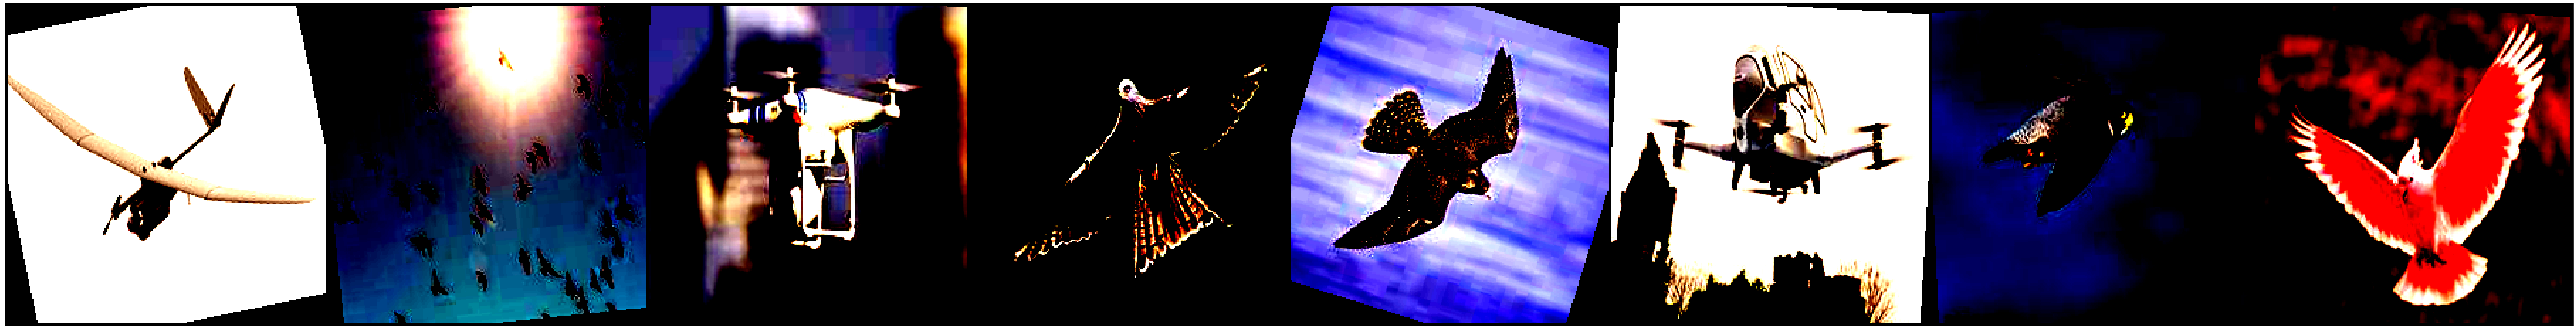

           [tensor(3)]            [tensor(0)]            [tensor(2)]            [tensor(0)]            [tensor(0)]            [tensor(1)]            [tensor(0)]            [tensor(0)]            [tensor(1)]            [tensor(1)]
time: 2min


In [25]:
import numpy as np
image, label = next(iter(train_loader))
show(image,label)

Load model
---

### Mobilenet_V2

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.hub.load('pytorch/vision:v0.6.0', MODEL, pretrained=True)
model.to(device)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

time: 5.42 s


#### Freeze and modify Classification layer

In [27]:
for param in model.parameters():
    param.requires_grad = False    

n_inputs = model.classifier[1].in_features

model.classifier = torch.nn.Sequential(torch.nn.Dropout(0.2),
                            torch.nn.Linear(n_inputs, 512),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(0.2),
                            torch.nn.Linear(512, 4),                            
                            torch.nn.LogSoftmax(dim=1))

time: 13.2 ms


In [28]:
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

time: 10.1 ms


In [29]:
# Print Summary
summary(model, input_size=(INPUT_CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

### Define loss function and optimizer

In [30]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=LEARNING_RATE,
    momentum=MOMENTUM,
    nesterov=True) 

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.1,
    patience=1,
    verbose=False, 
    threshold=0.000001,
    threshold_mode='abs',
    cooldown=0, 
    min_lr=1e-8,
    eps=1e-08
)

time: 6.67 ms


## Train Model

In [31]:
from torch.autograd import Variable
from tqdm import tqdm

def train_model(model, patience, n_epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    # early_stopping = EarlyStopping(patience=patience, verbose=True)
    early_stopping = EarlyStoppingOnAcc(patience=patience)
    
    for epoch in tqdm(range(1, n_epochs + 1)):
        for param_group in optimizer.param_groups:
          lr = param_group["lr"]
          print(f'\n **** learning rate: {lr}')
        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for inputs, target in train_loader:
            inputs, target = inputs.to(device), target.to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(inputs)
            # calculate the loss
            loss = criterion(output, target)
            
            # loss = Variable(loss, requires_grad = True)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())
            
        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        correct = 0
        total = 0
        accuracy = 0
        for inputs, target in val_loader:
            inputs, target = inputs.to(device), target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(inputs)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        
        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        valid_accuracy = 100 * correct / total

        epoch_len = len(str(n_epochs))

        print_msg = (f'\n[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'\tvalid_loss: {valid_loss:.5f}' +
                     f'\tvalid_accuracy: {valid_accuracy:.2f}')
        
        print(print_msg)

        # Tensorboard logging
        '''tb.add_scalar('Loss - Train loss',
                            train_loss / len(train_loader),
                            epoch * len(train_loader))
            
        tb.add_scalar('Loss - Val',
                        valid_loss/len(val_loader),
                        epoch * len(val_loader))
        
        tb.add_scalar('Accuracy - Val',
                            valid_accuracy/len(val_loader),
                            epoch * len(val_loader))'''
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        valid_accuracy = round(valid_accuracy, 2)
        scheduler.step(valid_accuracy)
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        model_path = 'checkpoint.pt' 
        early_stopping(valid_accuracy, model, model_path)

        if early_stopping.early_stop:
            print("Early stopping")
            if early_stopping.best_score is not None:
              print(f'Best score: {early_stopping.best_score}')
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(model_path))

    return  model, avg_train_losses, avg_valid_losses

time: 88.4 ms


In [32]:
model, train_loss, valid_loss = train_model(model, PATIENCE, EPOCHS)

  0%|          | 0/200 [00:00<?, ?it/s]


 **** learning rate: 0.01

[  1/200] train_loss: 0.78344 	valid_loss: 0.54427	valid_accuracy: 77.63
Validation score improved (-inf --> 77.63). Saving model!


  0%|          | 1/200 [2:32:44<506:35:07, 9164.36s/it]


 **** learning rate: 0.01

[  2/200] train_loss: 0.54949 	valid_loss: 0.51253	valid_accuracy: 80.02
Validation score improved (77.63 --> 80.02). Saving model!


  1%|          | 2/200 [2:36:58<357:01:07, 6491.25s/it]


 **** learning rate: 0.01


  2%|▏         | 3/200 [2:41:10<252:47:06, 4619.42s/it]


[  3/200] train_loss: 0.51896 	valid_loss: 0.51841	valid_accuracy: 79.00
EarlyStopping counter: 1 out of 10

 **** learning rate: 0.01


  2%|▏         | 4/200 [2:45:24<180:12:39, 3310.00s/it]


[  4/200] train_loss: 0.50973 	valid_loss: 0.52699	valid_accuracy: 79.05
EarlyStopping counter: 2 out of 10

 **** learning rate: 0.001

[  5/200] train_loss: 0.49732 	valid_loss: 0.48977	valid_accuracy: 80.81
Validation score improved (80.02 --> 80.81). Saving model!


  2%|▎         | 5/200 [2:49:39<129:38:33, 2393.40s/it]


 **** learning rate: 0.001

[  6/200] train_loss: 0.48281 	valid_loss: 0.47950	valid_accuracy: 80.94
Validation score improved (80.81 --> 80.94). Saving model!


  3%|▎         | 6/200 [2:53:55<94:25:20, 1752.17s/it] 


 **** learning rate: 0.001


  4%|▎         | 7/200 [2:58:11<69:52:44, 1303.44s/it]


[  7/200] train_loss: 0.48987 	valid_loss: 0.48243	valid_accuracy: 80.49
EarlyStopping counter: 1 out of 10

 **** learning rate: 0.001


  4%|▍         | 8/200 [3:02:29<52:46:32, 989.55s/it] 


[  8/200] train_loss: 0.48048 	valid_loss: 0.51990	valid_accuracy: 80.32
EarlyStopping counter: 2 out of 10

 **** learning rate: 0.0001


  4%|▍         | 9/200 [3:06:46<40:51:17, 770.04s/it]


[  9/200] train_loss: 0.48900 	valid_loss: 0.47912	valid_accuracy: 80.85
EarlyStopping counter: 3 out of 10

 **** learning rate: 0.0001


  5%|▌         | 10/200 [3:11:03<32:31:10, 616.16s/it]


[ 10/200] train_loss: 0.48279 	valid_loss: 0.49969	valid_accuracy: 80.85
EarlyStopping counter: 4 out of 10

 **** learning rate: 1e-05


  6%|▌         | 11/200 [3:15:24<26:44:35, 509.39s/it]


[ 11/200] train_loss: 0.48338 	valid_loss: 0.47939	valid_accuracy: 80.91
EarlyStopping counter: 5 out of 10

 **** learning rate: 1e-05


  6%|▌         | 12/200 [3:19:48<22:45:56, 435.94s/it]


[ 12/200] train_loss: 0.48331 	valid_loss: 0.49682	valid_accuracy: 80.88
EarlyStopping counter: 6 out of 10

 **** learning rate: 1.0000000000000002e-06


  6%|▋         | 13/200 [3:24:06<19:52:13, 382.53s/it]


[ 13/200] train_loss: 0.48354 	valid_loss: 0.48425	valid_accuracy: 80.74
EarlyStopping counter: 7 out of 10

 **** learning rate: 1.0000000000000002e-06


  7%|▋         | 14/200 [3:28:23<17:49:06, 344.87s/it]


[ 14/200] train_loss: 0.48945 	valid_loss: 0.49562	valid_accuracy: 80.58
EarlyStopping counter: 8 out of 10

 **** learning rate: 1.0000000000000002e-07


  8%|▊         | 15/200 [3:32:38<16:20:14, 317.92s/it]


[ 15/200] train_loss: 0.48557 	valid_loss: 0.48206	valid_accuracy: 80.86
EarlyStopping counter: 9 out of 10

 **** learning rate: 1.0000000000000002e-07

[ 16/200] train_loss: 0.48627 	valid_loss: 0.53551	valid_accuracy: 81.21
Validation score improved (80.94 --> 81.21). Saving model!


  8%|▊         | 16/200 [3:36:56<15:19:11, 299.74s/it]


 **** learning rate: 1.0000000000000002e-07


  8%|▊         | 17/200 [3:41:16<14:38:03, 287.89s/it]


[ 17/200] train_loss: 0.48363 	valid_loss: 0.48685	valid_accuracy: 80.89
EarlyStopping counter: 1 out of 10

 **** learning rate: 1.0000000000000002e-07


  9%|▉         | 18/200 [3:45:41<14:12:28, 281.04s/it]


[ 18/200] train_loss: 0.48166 	valid_loss: 0.48344	valid_accuracy: 80.28
EarlyStopping counter: 2 out of 10

 **** learning rate: 1.0000000000000004e-08

[ 19/200] train_loss: 0.48845 	valid_loss: 0.48619	valid_accuracy: 81.36
Validation score improved (81.21 --> 81.36). Saving model!


 10%|▉         | 19/200 [3:50:04<13:51:48, 275.74s/it]


 **** learning rate: 1.0000000000000004e-08


 10%|█         | 20/200 [3:54:15<13:25:03, 268.35s/it]


[ 20/200] train_loss: 0.48215 	valid_loss: 0.49255	valid_accuracy: 81.14
EarlyStopping counter: 1 out of 10

 **** learning rate: 1.0000000000000004e-08


 10%|█         | 21/200 [3:58:23<13:02:07, 262.16s/it]


[ 21/200] train_loss: 0.48231 	valid_loss: 0.48917	valid_accuracy: 80.60
EarlyStopping counter: 2 out of 10

 **** learning rate: 1.0000000000000004e-08


 11%|█         | 22/200 [4:02:27<12:41:44, 256.77s/it]


[ 22/200] train_loss: 0.48819 	valid_loss: 0.50108	valid_accuracy: 81.17
EarlyStopping counter: 3 out of 10

 **** learning rate: 1.0000000000000004e-08


 12%|█▏        | 23/200 [4:06:30<12:25:13, 252.62s/it]


[ 23/200] train_loss: 0.47668 	valid_loss: 0.48104	valid_accuracy: 81.33
EarlyStopping counter: 4 out of 10

 **** learning rate: 1.0000000000000004e-08


 12%|█▏        | 24/200 [4:10:34<12:12:55, 249.86s/it]


[ 24/200] train_loss: 0.48521 	valid_loss: 0.48235	valid_accuracy: 81.17
EarlyStopping counter: 5 out of 10

 **** learning rate: 1.0000000000000004e-08


 12%|█▎        | 25/200 [4:14:37<12:03:28, 248.05s/it]


[ 25/200] train_loss: 0.48566 	valid_loss: 0.49648	valid_accuracy: 80.71
EarlyStopping counter: 6 out of 10

 **** learning rate: 1.0000000000000004e-08


 13%|█▎        | 26/200 [4:18:42<11:56:02, 246.91s/it]


[ 26/200] train_loss: 0.47748 	valid_loss: 0.49234	valid_accuracy: 80.85
EarlyStopping counter: 7 out of 10

 **** learning rate: 1.0000000000000004e-08


 14%|█▎        | 27/200 [4:22:45<11:49:09, 245.95s/it]


[ 27/200] train_loss: 0.48074 	valid_loss: 0.48222	valid_accuracy: 80.80
EarlyStopping counter: 8 out of 10

 **** learning rate: 1.0000000000000004e-08


 14%|█▍        | 28/200 [4:26:50<11:43:44, 245.49s/it]


[ 28/200] train_loss: 0.48042 	valid_loss: 0.49045	valid_accuracy: 81.19
EarlyStopping counter: 9 out of 10

 **** learning rate: 1.0000000000000004e-08

[ 29/200] train_loss: 0.49086 	valid_loss: 0.50065	valid_accuracy: 80.64
EarlyStopping counter: 10 out of 10
Early stopping
Best score: 81.36
time: 4h 30min 55s


## Visualizing the loss

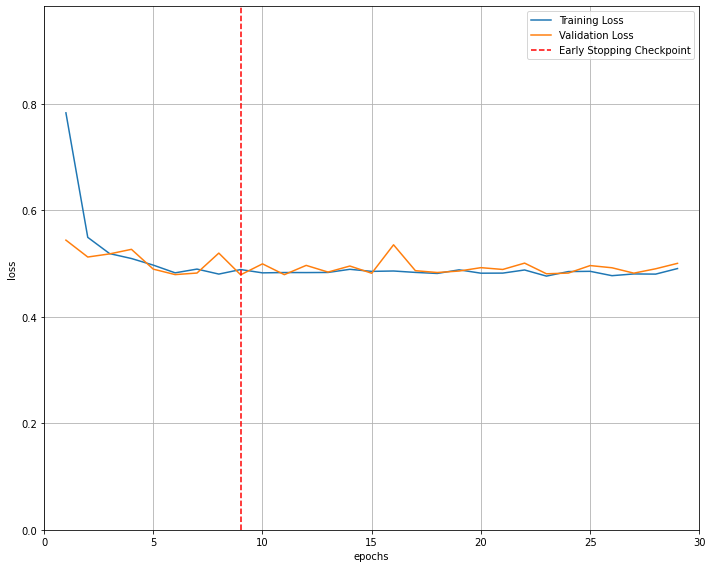

time: 457 ms


In [33]:
# visualize the loss as the network trained
displayloss(train_loss, valid_loss)

## Load the saved model

In [34]:
%cd '/content/drive/My Drive/eva-4/Phase-2/Session-2'

/content/drive/My Drive/eva-4/Phase-2/Session-2
time: 8.71 ms


In [35]:
model = torch.jit.load(MODEL_FILE)
print(model)

RecursiveScriptModule(
  original_name=MobileNetV2
  (features): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=ConvBNReLU
      (0): RecursiveScriptModule(original_name=Conv2d)
      (1): RecursiveScriptModule(original_name=BatchNorm2d)
      (2): RecursiveScriptModule(original_name=ReLU6)
    )
    (1): RecursiveScriptModule(
      original_name=InvertedResidual
      (conv): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(
          original_name=ConvBNReLU
          (0): RecursiveScriptModule(original_name=Conv2d)
          (1): RecursiveScriptModule(original_name=BatchNorm2d)
          (2): RecursiveScriptModule(original_name=ReLU6)
        )
        (1): RecursiveScriptModule(original_name=Conv2d)
        (2): RecursiveScriptModule(original_name=BatchNorm2d)
      )
    )
    (2): RecursiveScriptModule(
      original_name=InvertedResidual
      (conv): RecursiveScriptModule(
     

Misclassified Images
---

In [37]:
%cd '/content/drive/My Drive/eva-4/Phase-2/Session-2'

/content/drive/My Drive/eva-4/Phase-2/Session-2
time: 2.18 ms


In [38]:
class_list = ['Flying_Birds', 'Large_QuadCopters', 'Small QuadCopters', 'Winged Drones']
classes_short = ['FB', 'LQ', 'SQ', 'WD']

time: 1.01 ms


Misclassified images:



Misclassification for Flying_Birds..


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Misclassification for Large_QuadCopters..


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Misclassification for Small QuadCopters..


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Misclassification for Winged Drones..


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

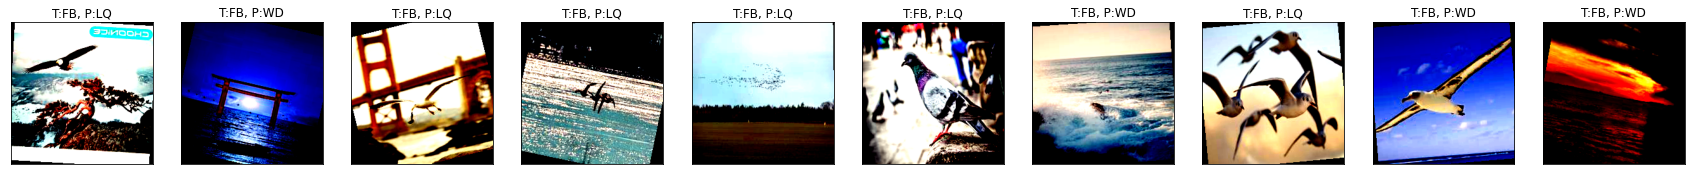

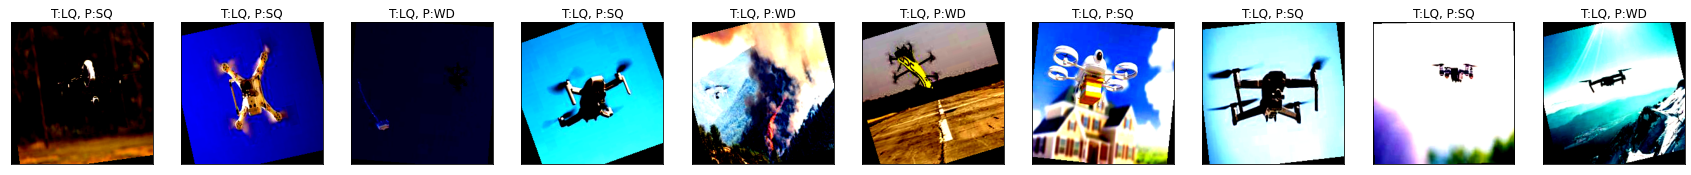

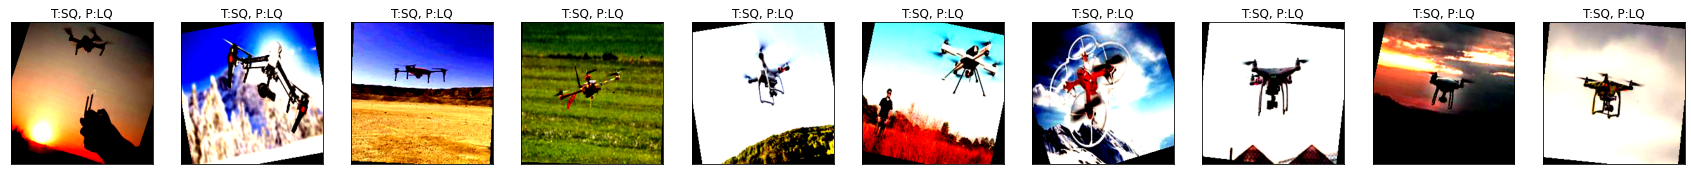

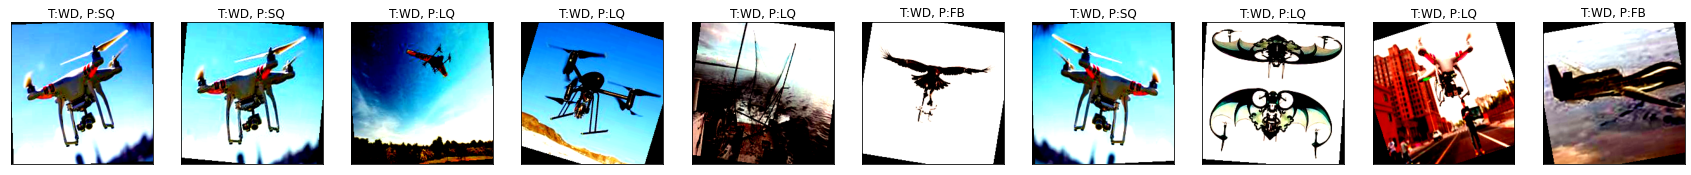

time: 31.8 s


In [39]:
print('Misclassified images:\n')
print('\n')
for idx, name in enumerate(class_list):
  print(f'Misclassification for {name}..')
  plot_misclassified_images_for_class(model, 
                                              testloader=val_loader, 
                                              classid=idx,
                                              figsize=(30,3),
                                              num_of_images=10, nrow=1, 
                                              save_filename=f'{BASE_COLAB_PATH}/{name}_misclassified_images.jpg')

## Setup in powershell

1. Start powershell in admin mode
2. Set execution policy 'Set-ExecutionPolicy Scope Process -ExecutionPolicy Bypass'
3.serverless plugin install --name serverless-python-requirements
4. npm run deploy
5. Grant permission to docker for file sharing
